In [1]:
import BioSimSpace as BSS
import glob
from rdkit import Chem
import csv
from sklearn.preprocessing import minmax_scale
import numpy as np

# to navigate the OS:
import os
import shutil

In [2]:
def getLigName(path):
    """Cleans up a path, retrieves the ligand name."""
    return path.split("/")[-1].replace(".sdf","")

In [3]:
def scaleArray(arr):
    """Scales an array to be the inverse in the range [0-1].
    This is needed because SEM predictions (0 good, 1 bad) are the inverse of LOMAP-Score (0 bad, 1 good). """
    
    # normalise to the range 0-1.
    return minmax_scale(1 /  np.array(arr), feature_range=(0,1))

In [4]:
links_file_name = "links_file.in"
work_dir = "runner_work_dir"
# first clean up if needed. BSS seems to mess up if some files are already there when it starts the below procedure.
if os.path.exists(work_dir) and os.path.isdir(work_dir):
    shutil.rmtree(work_dir)
    
if os.path.exists(links_file_name):
    os.remove(links_file_name)

In [5]:
ligands_rdkit = [Chem.SDMolSupplier(x)[0] for x in glob.glob("ClusterMolecules10/*.sdf")]
ligand_names = [getLigName(x) for x in glob.glob("ClusterMolecules10/*.sdf")]

# add indexing to ligand_names as a dict.
ligand_names_dict = {}
for i, lig in enumerate(ligand_names):
    i = "{0:0=3d}".format(i) # make the indexing have 3 digits, i.e. 001, 002, 003 etc.
    ligand_names_dict[lig] = f"{i}_{lig}.sdf"

In [6]:
true_perts = []
true_sems = []

with open("cluster_pair_preds.csv", "r") as readfile:
    reader = csv.reader(readfile)
    next(reader)
    # parse the SEM predictions file. Put the relevant data into separate lists.
    for row in reader:
        true_perts.append([ligand_names_dict[getLigName(row[0])], ligand_names_dict[getLigName(row[1])]])
        true_sems.append(float(row[-1]))
# scale the SEM predictions to fit the LOMAP-Score form.
true_sems = scaleArray(true_sems)

In [7]:
with open("links_file.in", "w") as writefile:
    writer = csv.writer(writefile, delimiter =" ")
    # write a 'links file' that contains all combinations of 
    # ligands and their SEM scores (that will replace LOMAP-Score.)
    for (a,b), value in zip(true_perts, true_sems):
        writer.writerow([a, b, value])

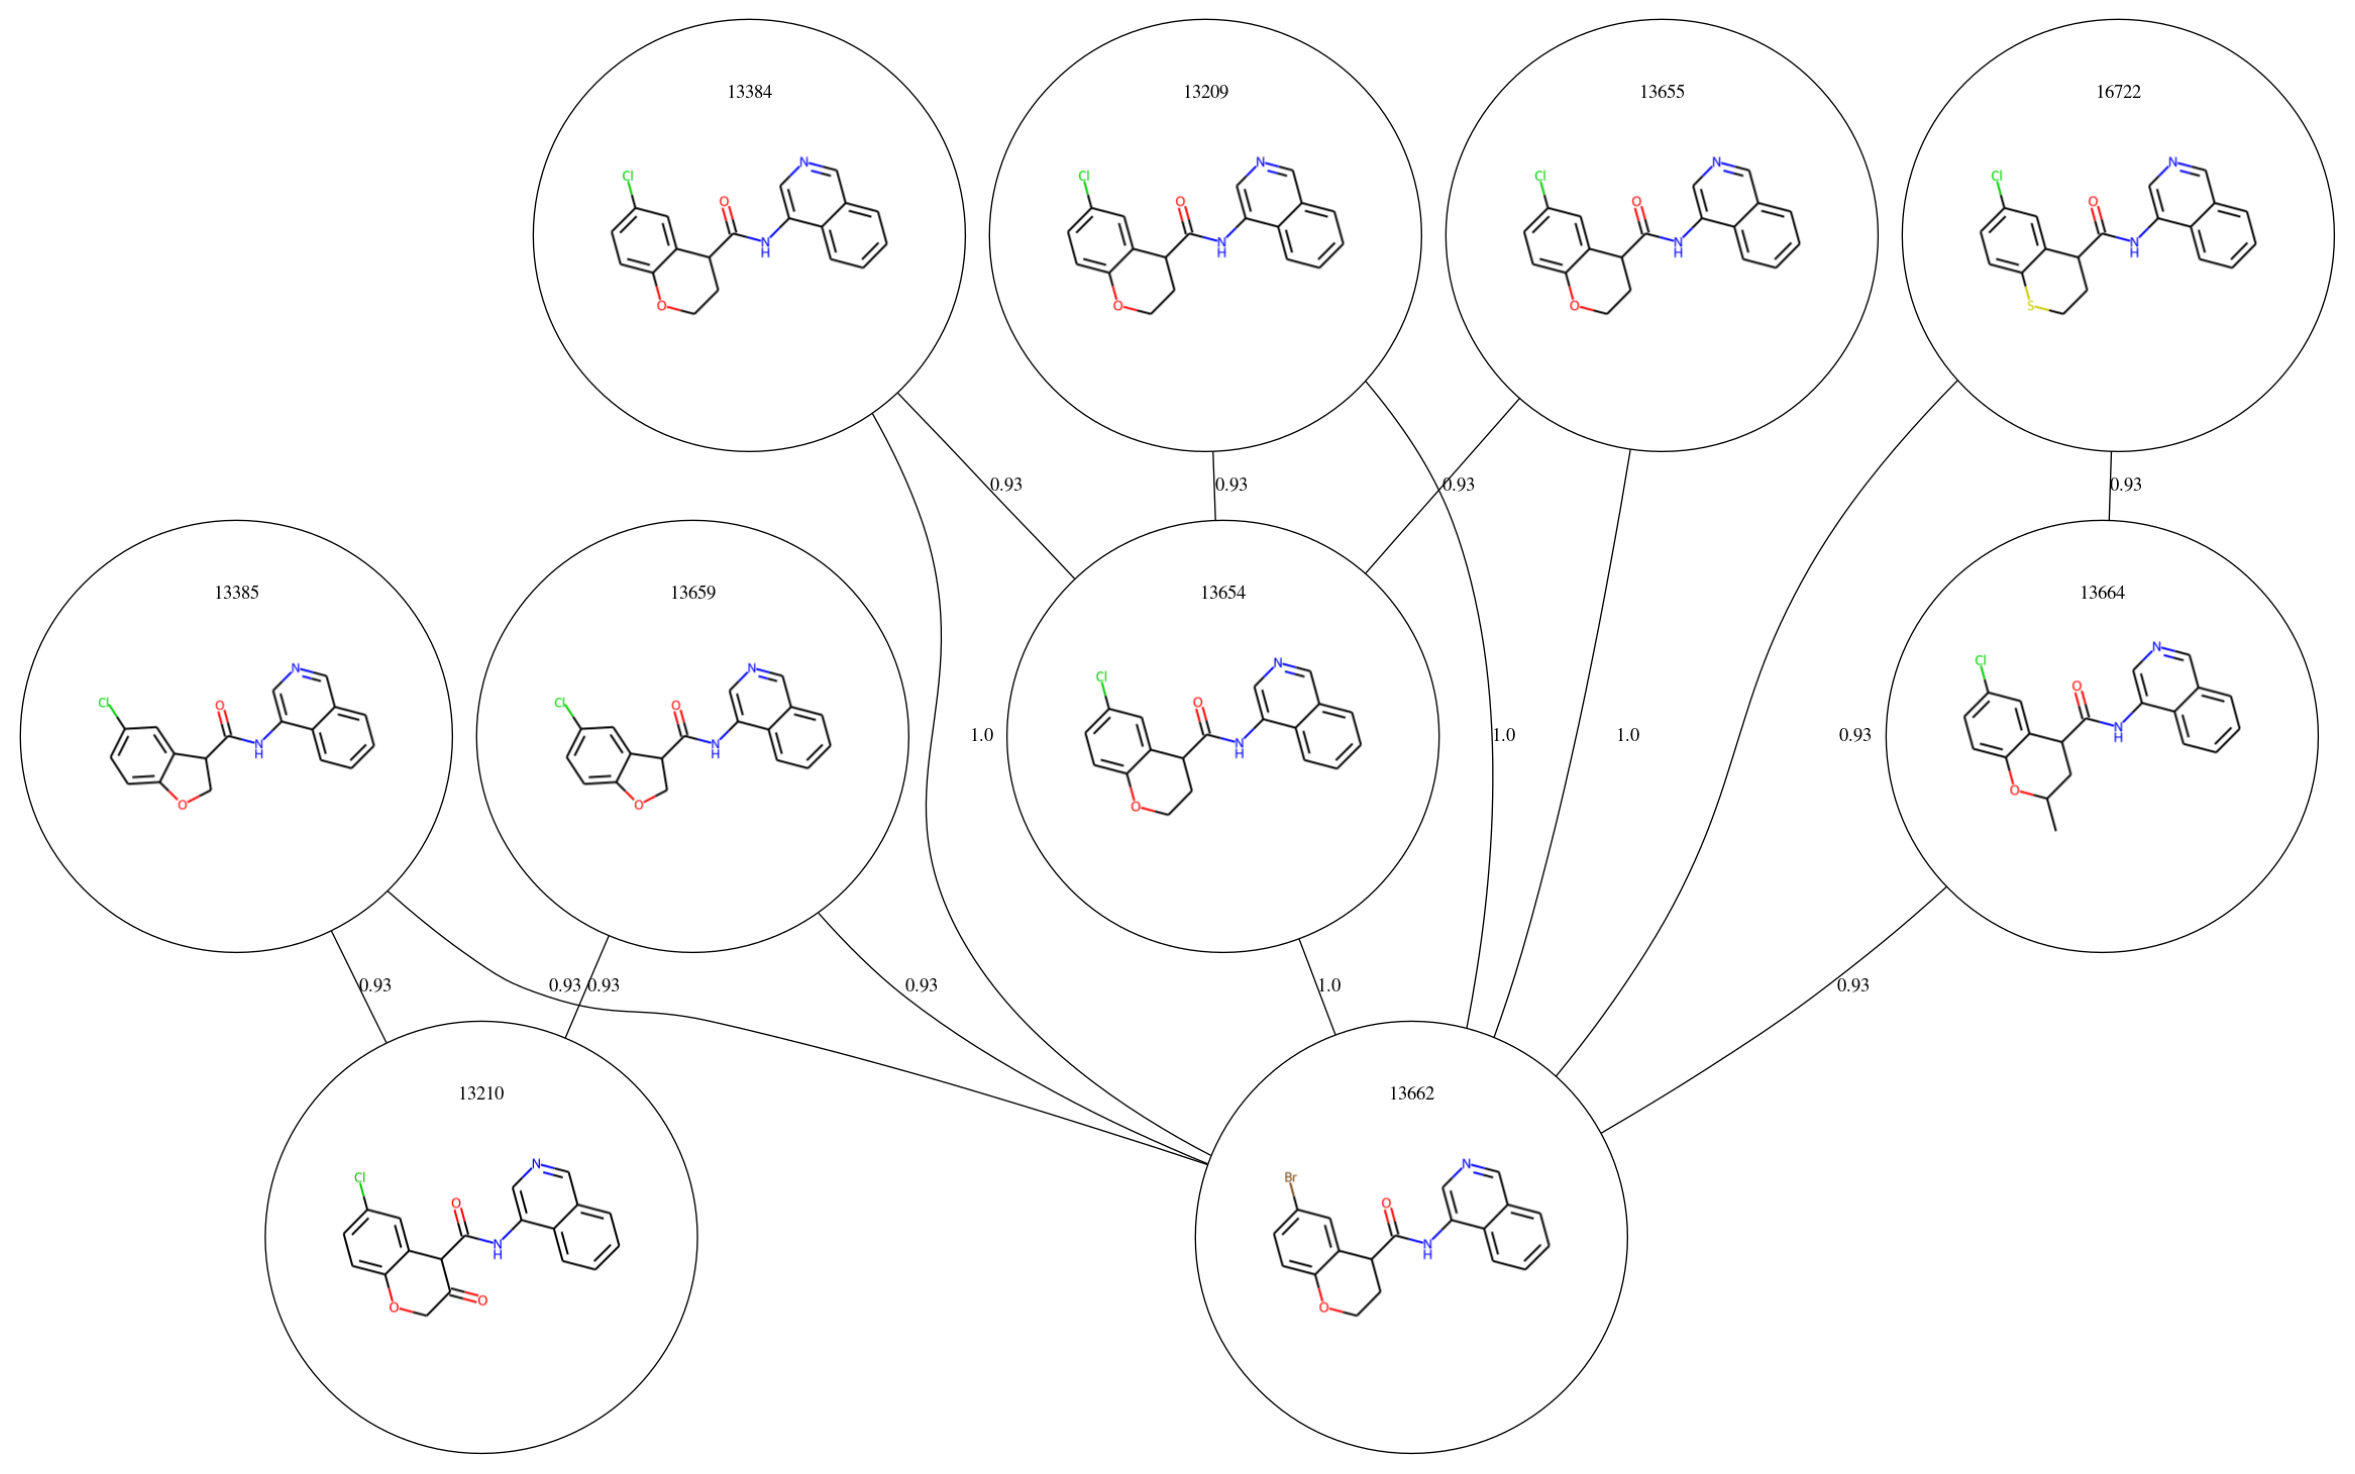

In [8]:
# generate the RBFENN network.
tranformations, lomap_scores = BSS.Align.generateNetwork(ligands_rdkit, plot_network=True, names=ligand_names, 
                                                         work_dir=work_dir,
                                                         links_file=links_file_name
                                                        )

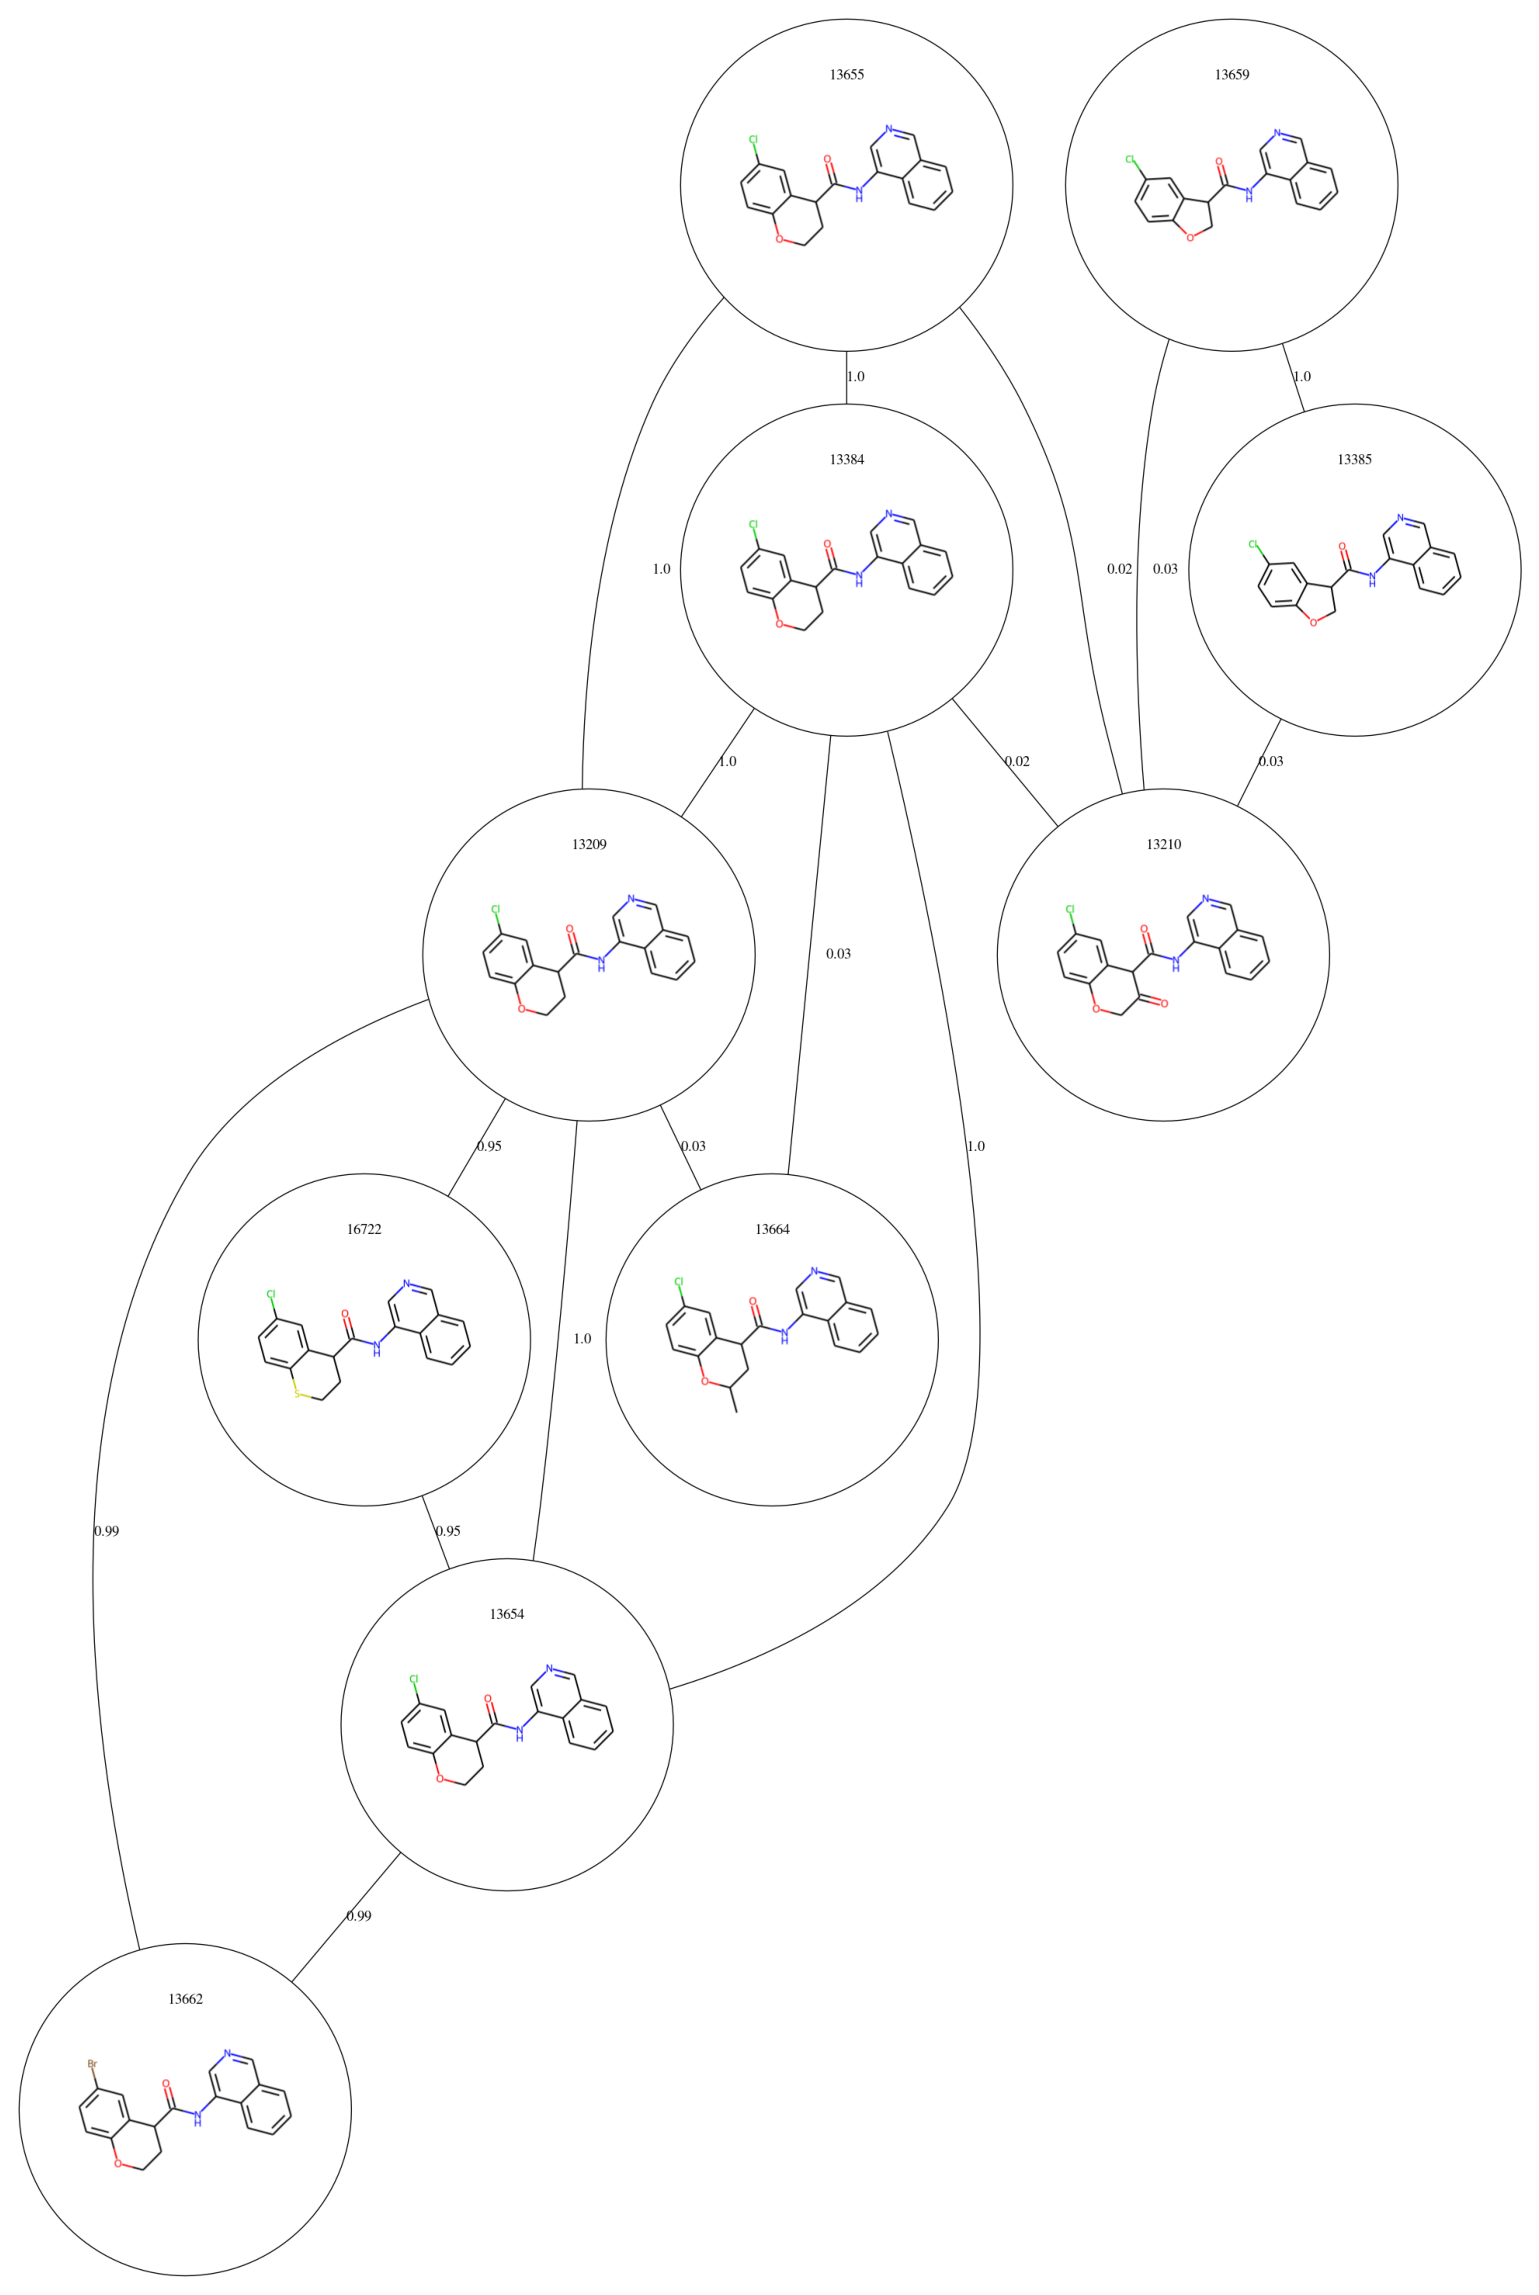

In [9]:
# generate the naive LOMAP network.
tranformations, lomap_scores = BSS.Align.generateNetwork(ligands_rdkit, plot_network=True, names=ligand_names, 
                                                         # work_dir=work_dir, # NB: if using this, make sure the folder doesn't already exist!
                                                         #links_file=links_file_name
                                                        )